In [1]:
!nvidia-smi

Wed May 28 04:29:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!ls /kaggle/input

voc2012  VOC2012


In [3]:
!ls /kaggle/input/VOC2012

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


In [4]:
base_path = '/kaggle/input/VOC2012'

In [5]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
# !tar -xf VOCtrainval_11-May-2012.tar

In [6]:
# !ls VOCdevkit/VOC2012

In [7]:
# base_path = 'VOCdevkit/VOC2012'

In [8]:
import os
import numpy as np
from PIL import Image
import albumentations as A

def load_voc_images(path, train=True, max_num=None):
    txt_file = os.path.join(path, 'ImageSets/Segmentation', 'train.txt' if train else 'val.txt')
    with open(txt_file, 'r') as f:
        file_names = [x.strip() for x in f.readlines()]

    if max_num is not None:
        file_names = file_names[:max_num]

    features, labels = [], []
    for fname in file_names:
        img_path = os.path.join(path, 'JPEGImages', fname + '.jpg')
        mask_path = os.path.join(path, 'SegmentationClass', fname + '.png')

        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            print(f"[Warning] Missing file: {fname}")
            continue

        # 加载 RGB 图像
        image = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert('RGB'))

        features.append(image)
        labels.append(mask)

    return features, labels


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [9]:
def get_transform_pipeline(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Affine(
                scale=(0.9, 1.1),
                translate_percent={"x": (-0.0625, 0.0625), "y": (-0.0625, 0.0625)},
                rotate=(-15, 15),
                p=0.5
            ),
            A.GaussianBlur(p=0.3),
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
        ])
    else:
        return A.Compose([
            A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225)),
        ])

def crop_and_augment_images(features, labels, crop_size, train=True, tolerance=10, bg_threshold=0.75):
    cropped_features, cropped_labels = [], []

    transform = get_transform_pipeline(train)

    for feature, label in zip(features, labels):
        h, w, _ = feature.shape
        if h < crop_size[0] or w < crop_size[1]:
            continue

        if train:
            for _ in range(tolerance):
                start_h = np.random.randint(0, h - crop_size[0] + 1)
                start_w = np.random.randint(0, w - crop_size[1] + 1)

                crop_feat = feature[start_h:start_h + crop_size[0], start_w:start_w + crop_size[1], :]
                crop_label = label[start_h:start_h + crop_size[0], start_w:start_w + crop_size[1], :]

                bg_mask = np.all(crop_label == 0, axis=-1)
                bg_ratio = np.mean(bg_mask)

                if bg_ratio <= bg_threshold:
                    augmented = transform(image=crop_feat, mask=crop_label)
                    cropped_features.append(augmented['image'])
                    cropped_labels.append(augmented['mask'])
                    break
        else:
            # 测试时直接居中裁剪并变换（只取一块）
            start_h = (h - crop_size[0]) // 2
            start_w = (w - crop_size[1]) // 2
            crop_feat = feature[start_h:start_h + crop_size[0], start_w:start_w + crop_size[1], :]
            crop_label = label[start_h:start_h + crop_size[0], start_w:start_w + crop_size[1], :]

            augmented = transform(image=crop_feat, mask=crop_label)
            cropped_features.append(augmented['image'])
            cropped_labels.append(augmented['mask'])

    return np.stack(cropped_features), np.stack(cropped_labels)

In [10]:
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
    [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
    [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
    [0, 64, 128]
]

VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor'
]

In [11]:
def build_colormap2label(colormap):
    cm2lbl = np.zeros(256 ** 3, dtype=np.uint8)
    for idx, color in enumerate(colormap):
        r, g, b = color
        cm2lbl[(r * 256 + g) * 256 + b] = idx
    return cm2lbl

cm2lbl = build_colormap2label(VOC_COLORMAP)

def voc_label_indices(label_img):
    data = label_img.astype('int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    return cm2lbl[idx]

def convert_voc_rgb_labels(y_list):
    return np.array([voc_label_indices(y) for y in y_list])

In [12]:
img_size = (256, 256)

In [13]:
def load_voc_dataset(train=True, max_num=None, crop_size=(256, 256)):
    features, labels = load_voc_images(base_path, train=train, max_num=max_num)

    features_cropped, labels_cropped = crop_and_augment_images(
        features, labels, crop_size=crop_size, train=train,
        bg_threshold=0.75 if train else 1.1  # >1.0 => 无过滤，但实际上本来就不会进入判断的逻辑
    )

    labels_cropped = convert_voc_rgb_labels(labels_cropped)

    return features_cropped.astype('float32'), labels_cropped.astype('int64')


In [14]:
X_train, y_train = load_voc_dataset(train=True, max_num=2000, crop_size=img_size)
X_test, y_test = load_voc_dataset(train=False, max_num=1000, crop_size=img_size)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1150, 256, 256, 3), (1150, 256, 256), (982, 256, 256, 3), (982, 256, 256))

In [16]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 16

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [17]:
dataloaders = {'train':train_loader, 'val':test_loader}
dataset_sizes = {'train':len(train_dataset), 'val':len(test_dataset)}

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device : {device}')

device : cuda


In [19]:
num_classes = 21 # 21分类，1个背景，20个物体

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

class FCNEnhanced(nn.Module):
    def __init__(self, num_classes=21, deep_supervision=False):
        super(FCNEnhanced, self).__init__()
        self.deep_supervision = deep_supervision

        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

        # ResNet前几层
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)  # [B, 64, H/4, W/4]
        self.layer1 = resnet.layer1  # [B, 256, H/4, W/4]
        self.layer2 = resnet.layer2  # [B, 512, H/8, W/8]
        self.layer3 = resnet.layer3  # [B, 1024, H/16, W/16]
        self.layer4 = resnet.layer4  # [B, 2048, H/32, W/32]

        # 主分割头
        self.head = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )

        # 跳跃连接映射到统一通道
        self.skip3 = nn.Conv2d(1024, num_classes, kernel_size=1)
        self.skip2 = nn.Conv2d(512, num_classes, kernel_size=1)

        # 融合模块（Concat后卷积）
        self.fuse1 = nn.Sequential(
            nn.Conv2d(2 * num_classes, num_classes, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_classes),
            nn.ReLU(inplace=True)
        )
        self.fuse2 = nn.Sequential(
            nn.Conv2d(2 * num_classes, num_classes, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_classes),
            nn.ReLU(inplace=True)
        )

        if self.deep_supervision:
            self.aux3 = nn.Conv2d(1024, num_classes, kernel_size=1)
            self.aux2 = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        input_size = x.shape[2:]

        x0 = self.layer0(x)       # [B, 64, H/4, W/4]
        x1 = self.layer1(x0)      # [B, 256, H/4, W/4]
        x2 = self.layer2(x1)      # [B, 512, H/8, W/8]
        x3 = self.layer3(x2)      # [B, 1024, H/16, W/16]
        x4 = self.layer4(x3)      # [B, 2048, H/32, W/32]

        # 主分类头输出
        x = self.head(x4)         # [B, C, H/32, W/32]
        x = F.interpolate(x, size=x3.shape[2:], mode='bilinear', align_corners=False)

        # 第一次融合
        x3_ = self.skip3(x3)
        x = torch.cat([x, x3_], dim=1)
        x = self.fuse1(x)
        x = F.interpolate(x, size=x2.shape[2:], mode='bilinear', align_corners=False)

        # 第二次融合
        x2_ = self.skip2(x2)
        x = torch.cat([x, x2_], dim=1)
        x = self.fuse2(x)

        # 上采样回原图
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

        if self.deep_supervision:
            aux_out3 = F.interpolate(self.aux3(x3), size=input_size, mode='bilinear', align_corners=False)
            aux_out2 = F.interpolate(self.aux2(x2), size=input_size, mode='bilinear', align_corners=False)
            return x, aux_out3, aux_out2

        return x


In [21]:
model = FCNEnhanced(num_classes=num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


In [22]:
import time
import copy

In [23]:
def train_model(
    model: nn.Module,
    criterion,
    optimizer,
    scheduler,
    num_epochs=20,
    patience=5,
    update_iou_epoch=10,
    num_classes=21,
    device='cuda'):
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    no_improve_epochs = 0

    print(f"{'='*30}\nStarting training...\n{'='*30}")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # [B, C, H, W]
                    loss_ce = criterion(outputs, labels)
                    loss_entropy = entropy_regularization_ignore_bg(outputs, labels)
                    loss = loss_ce + loss_entropy

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            if phase == 'val':
                metrics = evaluate_segmentation_metrics(
                    model, dataloaders['val'],
                    num_classes=num_classes, device=device,
                    metrics=('acc', 'iou')
                )
                epoch_acc = metrics['PA']
                epoch_miou = metrics['mIoU']
                print(f"{phase.capitalize():<6} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | mIoU: {epoch_miou:.4f}")

                # Early stopping 判断
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    no_improve_epochs = 0
                    print(f"{' '*8}↑ New best model saved (Acc: {best_acc:.4f})")
                else:
                    no_improve_epochs += 1
                    print(f"{' '*8}↳ No improvement ({no_improve_epochs}/{patience})")
            else:
                print(f"{phase.capitalize():<6} | Loss: {epoch_loss:.4f}")

        scheduler.step()

        # 更新 IoU 权重
        if (epoch + 1) % update_iou_epoch == 0:
            metrics = evaluate_segmentation_metrics(
                model, dataloaders['val'],
                num_classes=num_classes, device=device,
                metrics=('iou',)
            )
            iou_per_class = metrics['IoU_per_class']
            new_weights = compute_class_weights_from_iou(iou_per_class, device=device)
            criterion = nn.CrossEntropyLoss(weight=new_weights)
            print(f"→ Updated class weights based on IoU: {new_weights.cpu().numpy().round(4)}")

        if no_improve_epochs >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs with no improvement.")
            break

    time_elapsed = time.time() - since
    print(f"\n{'='*30}")
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Validation Accuracy: {best_acc:.4f}")
    print(f"{'='*30}")

    model.load_state_dict(best_model_wts)
    return model


In [24]:
def evaluate_segmentation_metrics(model, dataloader, num_classes=21, device='cuda', metrics=('acc', 'iou')):
    model.eval()
    total_correct = 0
    total_pixels = 0
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            if 'acc' in metrics:
                total_correct += (preds == labels).sum().item()
                total_pixels += torch.numel(labels)

            if 'iou' in metrics or 'mpa' in metrics:
                for cls in range(num_classes):
                    pred_mask = (preds == cls)
                    label_mask = (labels == cls)

                    class_correct[cls] += (pred_mask & label_mask).sum().item()
                    class_total[cls] += label_mask.sum().item()
                    intersection[cls] += (pred_mask & label_mask).sum().item()
                    union[cls] += (pred_mask | label_mask).sum().item()

    results = {}

    if 'acc' in metrics:
        pixel_acc = total_correct / total_pixels
        results['PA'] = pixel_acc

    if 'mpa' in metrics:
        class_acc = class_correct / (class_total + 1e-6)
        results['MPA'] = np.mean(class_acc)

    if 'iou' in metrics:
        iou_per_class = intersection / (union + 1e-6)
        results['mIoU'] = np.mean(iou_per_class)
        results['IoU_per_class'] = iou_per_class

    return results

In [25]:
def entropy_regularization_ignore_bg(logits, labels, lambda_entropy=0.01, ignore_index=0):

    probs = F.softmax(logits, dim=1) + 1e-8  # 防止 log(0)
    log_probs = torch.log(probs)
    entropy = -torch.sum(probs * log_probs, dim=1)  # [B, H, W]

    # 创建 mask，仅对非背景像素（标签 ≠ ignore_index）进行惩罚
    with torch.no_grad():
        mask = (labels != ignore_index).float()  # [B, H, W]

    masked_entropy = entropy * mask
    mean_entropy = masked_entropy.sum() / (mask.sum() + 1e-8)  # 避免除0

    return lambda_entropy * mean_entropy


In [26]:
def compute_class_weights_from_iou(iou_per_class, device='cuda'):

    epsilon = 1e-6
    iou = np.array(iou_per_class)
    weights = 1.0 / (iou + epsilon)
    weights = weights / weights.mean()  # 保持均值为 1
    return torch.tensor(weights, dtype=torch.float32).to(device)

In [27]:
import torch.optim as optim 

num_epochs = 100
patience = 10
learning_rate = 1e-3
lr_step_size = 10
lr_gamma = 0.1
    
criterion = torch.nn.CrossEntropyLoss(weight=None)    # 初始不设定权重

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

model = train_model(model, criterion, optimizer, lr_scheduler, num_epochs=num_epochs, patience=patience)
torch.save(model.state_dict(), 'model.pth')
print(f"Model saved to 'model.pth'")

Starting training...

Epoch 1/100
------------------------------
Train  | Loss: 2.5223
Val    | Loss: 2.3070 | Acc: 0.5597 | mIoU: 0.1409
        ↑ New best model saved (Acc: 0.5597)

Epoch 2/100
------------------------------
Train  | Loss: 2.2691
Val    | Loss: 2.1371 | Acc: 0.6070 | mIoU: 0.1794
        ↑ New best model saved (Acc: 0.6070)

Epoch 3/100
------------------------------
Train  | Loss: 2.1269
Val    | Loss: 2.0821 | Acc: 0.6258 | mIoU: 0.1988
        ↑ New best model saved (Acc: 0.6258)

Epoch 4/100
------------------------------
Train  | Loss: 1.9985
Val    | Loss: 2.0433 | Acc: 0.6287 | mIoU: 0.2102
        ↑ New best model saved (Acc: 0.6287)

Epoch 5/100
------------------------------
Train  | Loss: 1.8716
Val    | Loss: 1.9168 | Acc: 0.6432 | mIoU: 0.2159
        ↑ New best model saved (Acc: 0.6432)

Epoch 6/100
------------------------------
Train  | Loss: 1.7178
Val    | Loss: 1.8383 | Acc: 0.6671 | mIoU: 0.2484
        ↑ New best model saved (Acc: 0.6671)

Epoch 

In [28]:
def label2image(pred):
    colormap = torch.tensor(VOC_COLORMAP, device=device, dtype=int)
    x = pred.long()
    return (colormap[x,:]).data.cpu().numpy()

In [29]:
import matplotlib.pyplot as plt

def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    return img_tensor * std + mean

def visualize_predictions(model, dataloader, device, num_images=3):
    model.eval()
    images_displayed = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.shape[0]):
                if images_displayed >= num_images:
                    return

                img = images[i].permute(1, 2, 0).cpu().numpy()  # [3,H,W] → [H,W,3]
                img = np.clip(img, 0, 1)

                label = label2image(labels[i])
                pred = label2image(preds[i])
                
                img = denormalize(images[i]).permute(1, 2, 0).cpu().numpy()

                plt.figure(figsize=(10, 3))
                plt.subplot(1, 3, 1)
                plt.imshow(img)
                plt.title('Input Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(label)
                plt.title('Ground Truth')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred)
                plt.title('Prediction')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                images_displayed += 1


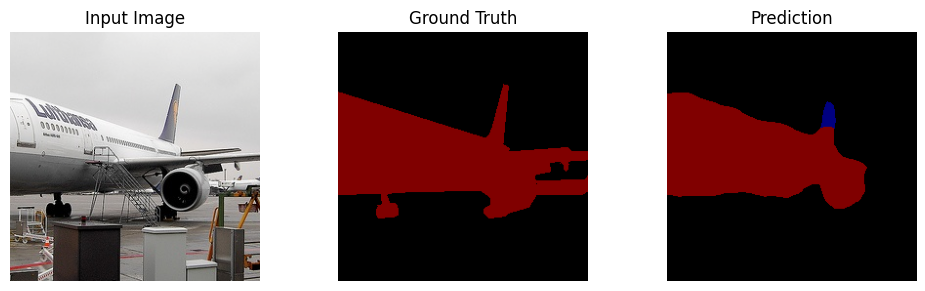

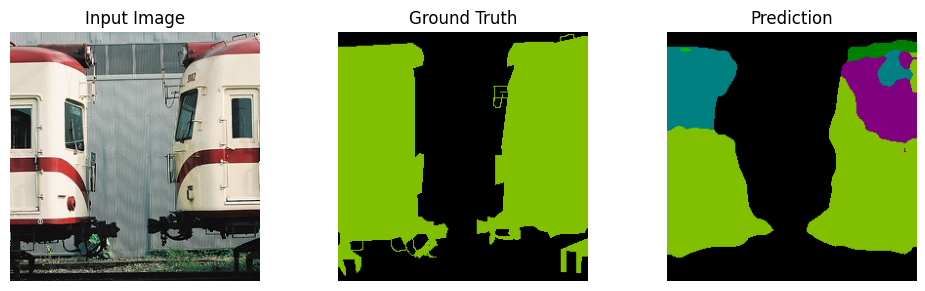

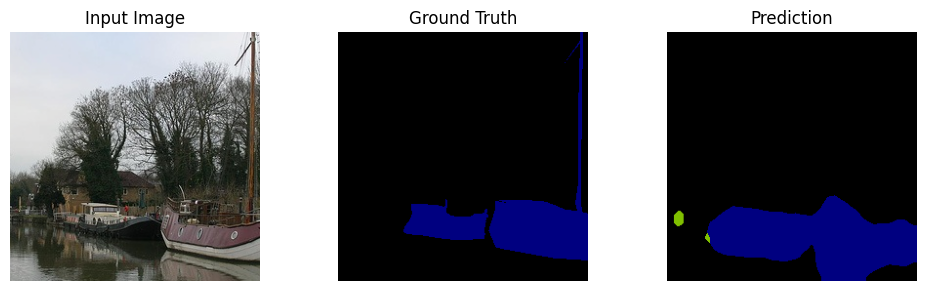

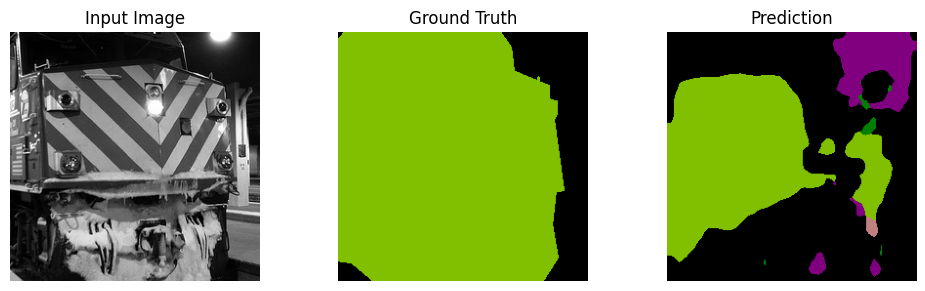

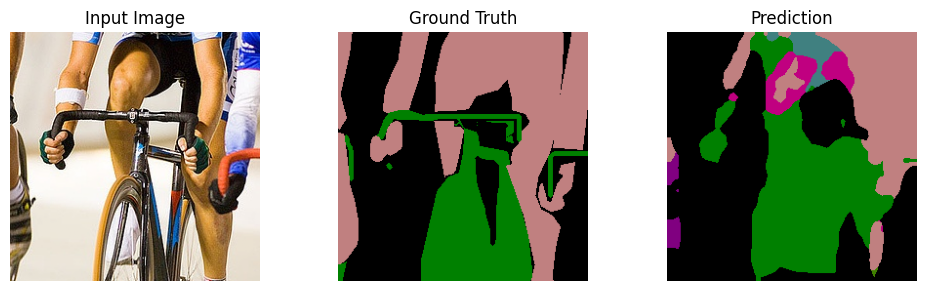

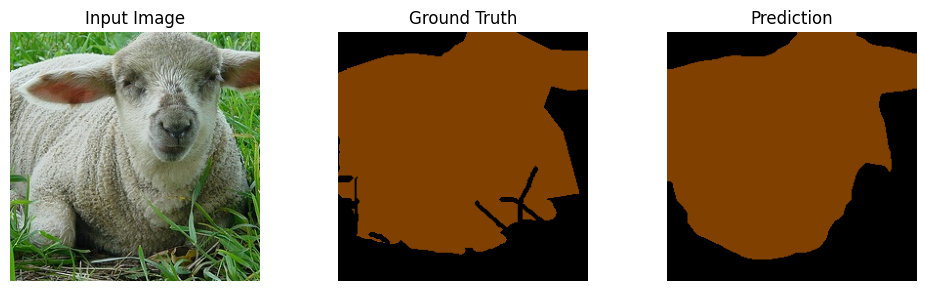

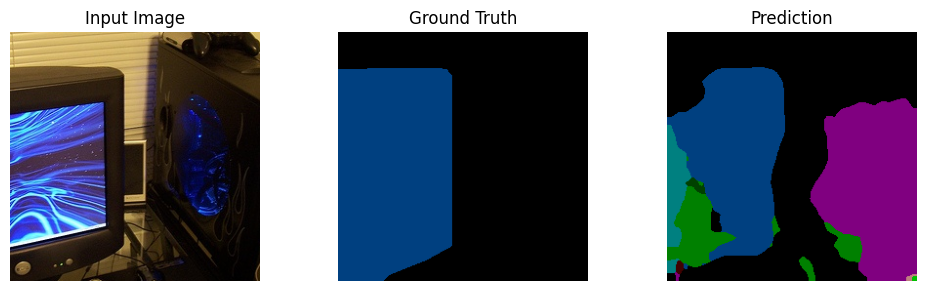

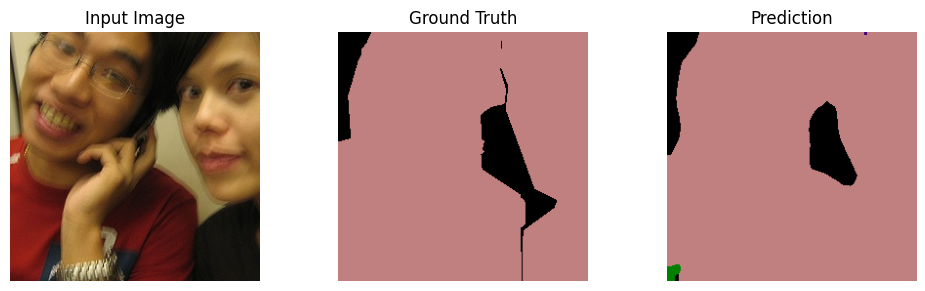

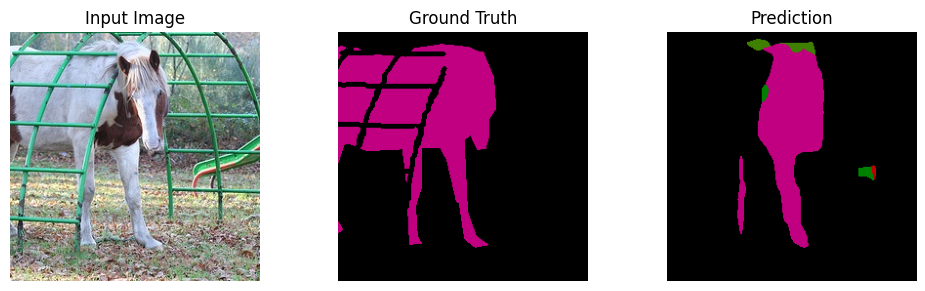

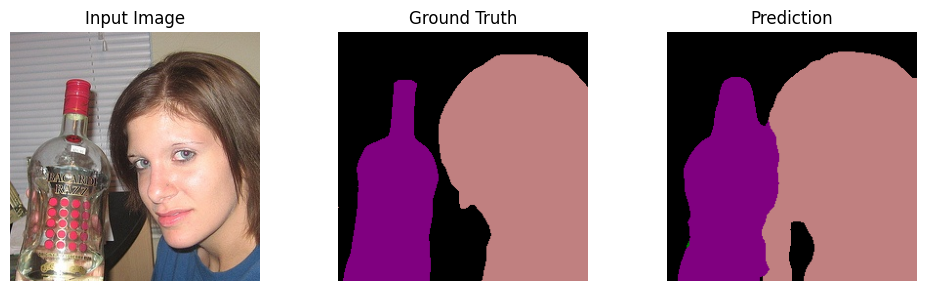

In [30]:
visualize_predictions(model, dataloaders['val'], device, num_images=10)

In [31]:
evaluate_segmentation_metrics(
    model,
    dataloaders['val'],
    num_classes=num_classes,
    device=device,
    metrics=('acc', 'mpa', 'iou')
)

{'PA': 0.7588018972859121,
 'MPA': 0.5686386514972535,
 'mIoU': 0.392229290148772,
 'IoU_per_class': array([0.77981167, 0.52487221, 0.16888971, 0.39717173, 0.32955102,
        0.33539896, 0.57627196, 0.49708124, 0.42545526, 0.12045542,
        0.24088262, 0.26251476, 0.32703677, 0.32263817, 0.43762436,
        0.65565975, 0.26165513, 0.38229109, 0.1860592 , 0.57406254,
        0.43143154])}